In [1]:
# uploading files
# source: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
from google.colab import files
uploaded = files.upload()

Saving forest_cover.csv to forest_cover.csv


# Nonparametric ML Models - Cumulative Lab

## Introduction

In this cumulative lab, you will apply two nonparametric models you have just learned — k-nearest neighbors and decision trees — to the forest cover dataset.

## Objectives

* Practice identifying and applying appropriate preprocessing steps
* Perform an iterative modeling process, starting from a baseline model
* Explore multiple model algorithms, and tune their hyperparameters
* Practice choosing a final model across multiple model algorithms and evaluating its performance

## Your Task: Complete an End-to-End ML Process with Nonparametric Models on the Forest Cover Dataset

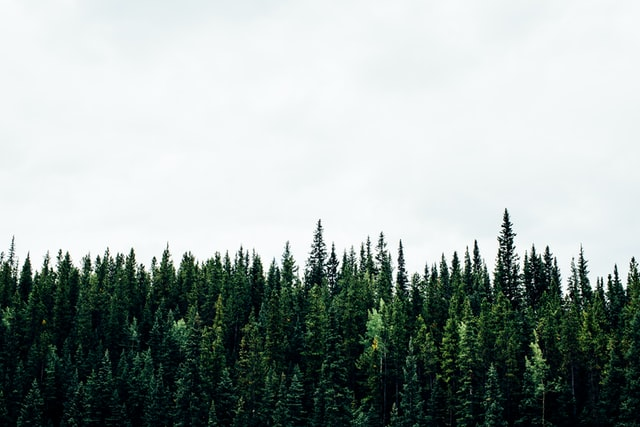

Photo by <a href="https://unsplash.com/@michaelbenz?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Michael Benz</a> on <a href="/s/photos/forest?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Business and Data Understanding

To repeat the previous description:

> Here we will be using an adapted version of the forest cover dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/covertype). Each record represents a 30 x 30 meter cell of land within Roosevelt National Forest in northern Colorado, which has been labeled as `Cover_Type` 1 for "Cottonwood/Willow" and `Cover_Type` 0 for "Ponderosa Pine". (The original dataset contained 7 cover types but we have simplified it.)

The task is to predict the `Cover_Type` based on the available cartographic variables:

In [2]:
# Run this cell without changes
import pandas as pd

df = pd.read_csv('forest_cover.csv')
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2553,235,17,351,95,780,188,253,199,1410,...,0,0,0,0,0,0,0,0,0,0
1,2011,344,17,313,29,404,183,211,164,300,...,0,0,0,0,0,0,0,0,0,0
2,2022,24,13,391,42,509,212,212,134,421,...,0,0,0,0,0,0,0,0,0,0
3,2038,50,17,408,71,474,226,200,102,283,...,0,0,0,0,0,0,0,0,0,0
4,2018,341,27,351,34,390,152,188,168,190,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38496,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,0
38497,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,0
38498,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,0
38499,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,0


> As you can see, we have over 38,000 rows, each with 52 feature columns and 1 target column:

> * `Elevation`: Elevation in meters
> * `Aspect`: Aspect in degrees azimuth
> * `Slope`: Slope in degrees
> * `Horizontal_Distance_To_Hydrology`: Horizontal dist to nearest surface water features in meters
> * `Vertical_Distance_To_Hydrology`: Vertical dist to nearest surface water features in meters
> * `Horizontal_Distance_To_Roadways`: Horizontal dist to nearest roadway in meters
> * `Hillshade_9am`: Hillshade index at 9am, summer solstice
> * `Hillshade_Noon`: Hillshade index at noon, summer solstice
> * `Hillshade_3pm`: Hillshade index at 3pm, summer solstice
> * `Horizontal_Distance_To_Fire_Points`: Horizontal dist to nearest wildfire ignition points, meters
> * `Wilderness_Area_x`: Wilderness area designation (3 columns)
> * `Soil_Type_x`: Soil Type designation (39 columns)
> * `Cover_Type`: 1 for cottonwood/willow, 0 for ponderosa pine

This is also an imbalanced dataset, since cottonwood/willow trees are relatively rare in this forest:

In [3]:
# Run this cell without changes
print("Raw Counts")
print(df["Cover_Type"].value_counts())
print()
print("Percentages")
print(df["Cover_Type"].value_counts(normalize=True))

Raw Counts
0    35754
1     2747
Name: Cover_Type, dtype: int64

Percentages
0    0.928651
1    0.071349
Name: Cover_Type, dtype: float64


Thus, a baseline model that always chose the majority class would have an accuracy of over 92%. Therefore we will want to report additional metrics at the end.

### Previous Best Model

In a previous lab, we used SMOTE to create additional synthetic data, then tuned the hyperparameters of a logistic regression model to get the following final model metrics:

* **Log loss:** 0.13031294393913376
* **Accuracy:** 0.9456679825472678
* **Precision:** 0.6659919028340081
* **Recall:** 0.47889374090247455

In this lab, you will try to beat those scores using more-complex, nonparametric models.

### Modeling

Although you may be aware of some additional model algorithms available from scikit-learn, for this lab you will be focusing on two of them: k-nearest neighbors and decision trees. Here are some reminders about these models:

#### kNN - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

This algorithm — unlike linear models or tree-based models — does not emphasize learning the relationship between the features and the target. Instead, for a given test record, it finds the most similar records in the training set and returns an average of their target values.

* **Training speed:** Fast. In theory it's just saving the training data for later, although the scikit-learn implementation has some additional logic "under the hood" to make prediction faster.
* **Prediction speed:** Very slow. The model has to look at every record in the training set to find the k closest to the new record.
* **Requires scaling:** Yes. The algorithm to find the nearest records is distance-based, so it matters that distances are all on the same scale.
* **Key hyperparameters:** `n_neighbors` (how many nearest neighbors to find; too few neighbors leads to overfitting, too many leads to underfitting), `p` and `metric` (what kind of distance to use in defining "nearest" neighbors)

#### Decision Trees - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Similar to linear models (and unlike kNN), this algorithm emphasizes learning the relationship between the features and the target. However, unlike a linear model that tries to find linear relationships between each of the features and the target, decision trees look for ways to split the data based on features to decrease the entropy of the target in each split.

* **Training speed:** Slow. The model is considering splits based on as many as all of the available features, and it can split on the same feature multiple times. This requires exponential computational time that increases based on the number of columns as well as the number of rows.
* **Prediction speed:** Medium fast. Producing a prediction with a decision tree means applying several conditional statements, which is slower than something like logistic regression but faster than kNN.
* **Requires scaling:** No. This model is not distance-based. You also can use a `LabelEncoder` rather than `OneHotEncoder` for categorical data, since this algorithm doesn't necessarily assume that the distance between `1` and `2` is the same as the distance between `2` and `3`.
* **Key hyperparameters:** Many features relating to "pruning" the tree. By default they are set so the tree can overfit, and by setting them higher or lower (depending on the hyperparameter) you can reduce overfitting, but too much will lead to underfitting. These are: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, and `min_impurity_decrease`. You can also try changing the `criterion` to "entropy" or the `splitter` to "random" if you want to change the splitting logic.

### Requirements

#### 1. Prepare the Data for Modeling

#### 2. Build a Baseline kNN Model

#### 3. Build Iterative Models to Find the Best kNN Model

#### 4. Build a Baseline Decision Tree Model

#### 5. Build Iterative Models to Find the Best Decision Tree Model

#### 6. Choose and Evaluate an Overall Best Model

## 1. Prepare the Data for Modeling

The target is `Cover_Type`. In the cell below, split `df` into `X` and `y`, then perform a train-test split with `random_state=42` and `stratify=y` to create variables with the standard `X_train`, `X_test`, `y_train`, `y_test` names.

Include the relevant imports as you go.

In [39]:
# Your code here
from sklearn.model_selection import train_test_split

X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Now, instantiate a `StandardScaler`, fit it on `X_train`, and create new variables `X_train_scaled` and `X_test_scaled` containing values transformed with the scaler.

In [40]:
# Your code here
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

The following code checks that everything is set up correctly:

In [6]:
# Run this cell without changes

# Checking that df was separated into correct X and y
assert type(X) == pd.DataFrame and X.shape == (38501, 52)
assert type(y) == pd.Series and y.shape == (38501,)

# Checking the train-test split
assert type(X_train) == pd.DataFrame and X_train.shape == (28875, 52)
assert type(X_test) == pd.DataFrame and X_test.shape == (9626, 52)
assert type(y_train) == pd.Series and y_train.shape == (28875,)
assert type(y_test) == pd.Series and y_test.shape == (9626,)

# Checking the scaling
assert X_train_scaled.shape == X_train.shape
assert round(X_train_scaled[0][0], 3) == -0.636
assert X_test_scaled.shape == X_test.shape
assert round(X_test_scaled[0][0], 3) == -1.370

## 2. Build a Baseline kNN Model

Build a scikit-learn kNN model with default hyperparameters. Then use `cross_val_score` with `scoring="neg_log_loss"` to find the mean log loss for this model (passing in `X_train_scaled` and `y_train` to `cross_val_score`). You'll need to find the mean of the cross-validated scores, and negate the value (either put a `-` at the beginning or multiply by `-1`) so that your answer is a log loss rather than a negative log loss.

Call the resulting score `knn_baseline_log_loss`.

Your code might take a minute or more to run.

In [41]:
# Replace None with appropriate code

# Relevant imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating the model
knn_baseline_model = KNeighborsClassifier()

# Perform cross-validation
knn_baseline_log_loss = -cross_val_score(knn_baseline_model, X_train_scaled, y_train, scoring="neg_log_loss").mean()

knn_baseline_log_loss

0.12964546386734577

Our best logistic regression model had a log loss of 0.13031294393913376

Is this model better? Compare it in terms of metrics and speed.

In [ ]:
# Replace None with appropriate text
"""
The baseline model has a lower log loss and it didn't take long to run in my notebook. However the difference is slight and I don't know the business problem
so it is hard to say which one is really better. Going off the log loss alone, the baseline performed better.
"""

## 3. Build Iterative Models to Find the Best kNN Model

Build and evaluate at least two more kNN models to find the best one. Explain why you are changing the hyperparameters you are changing as you go. These models will be *slow* to run, so be thinking about what you might try next as you run them.

In [42]:
# Your code here (add more cells as needed)  weights='distance'

# This model gives more weight to closer neighbors
knn_closer_model = KNeighborsClassifier(weights='distance')

knn_closer_model.fit(X_train, y_train)


KNeighborsClassifier(weights='distance')

In [12]:
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score,  confusion_matrix,\
precision_recall_fscore_support, f1_score, roc_auc_score, roc_curve

In [43]:
# Your code here (add more cells as needed)
y_pred = knn_closer_model.predict(X_test_scaled)

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy: 92.86307916060669
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
knn_closer_log_loss_mean = -cross_val_score(knn_closer_model, X_train_scaled, y_train, scoring="neg_log_loss").mean()
knn_closer_log_loss_mean

0.1263839716580627

In [46]:
# This model gives more weight to closer neighbors and adds more neighbors
knn_closer_more_neighbors_model = KNeighborsClassifier(n_neighbors=7, weights='distance')

knn_closer_more_neighbors_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

In [47]:
# Your code here (add more cells as needed)
y_pred = knn_closer_more_neighbors_model.predict(X_test_scaled)

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy: 92.86307916060669
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
knn_closer_more_neigh_log_loss_mean = -cross_val_score(knn_closer_more_neighbors_model, X_train_scaled, y_train, scoring="neg_log_loss").mean()
knn_closer_more_neigh_log_loss_mean

0.08798017410189538

In [ ]:
"""
Employing the log loss metric, weighting the closer neighbors beat the baseline model. Then adding more neighbors (7 from the default 5) outperforms both the baseline model and the
'knn_closer_model' that weighted the closer neighbors more heavily but left the n_neighbors with the default 5. Yet both models seem to be predicting the majority class based on the accuracy scores above.
"""

## 4. Build a Baseline Decision Tree Model

Now that you have chosen your best kNN model, start investigating decision tree models. First, build and evaluate a baseline decision tree model, using default hyperparameters (with the exception of `random_state=42` for reproducibility).

(Use cross-validated log loss, just like with the previous models.)

In [22]:
# Your code here
from sklearn.tree import DecisionTreeClassifier,  plot_tree
# Instantiate and fit decision tree model
tree_clf = DecisionTreeClassifier(random_state=42)
# train the model
tree_clf.fit(X_train, y_train)
# evaulate the model

tree_baseline_log_loss_mean = -cross_val_score(tree_clf, X_train_scaled, y_train, scoring="neg_log_loss").mean()
tree_baseline_log_loss_mean


0.7364763809378052

In [23]:
# Your code here (add more cells as needed)
y_pred = tree_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))

Accuracy: 97.82879700810305
Precision: 0.8319444444444445
Recall: 0.8719068413391557
F1 Score: 0.8514570007107322


Interpret this score. How does this compare to the log loss from our best logistic regression and best kNN models? Any guesses about why?

In [ ]:
# Replace None with appropriate text
"""
Decision Trees are prone to overfitting so it makes sense that the baseline decision tree would score much worse than our best performing
logistic regression and KNN mmodels.
"""

## 5. Build Iterative Models to Find the Best Decision Tree Model

Build and evaluate at least two more decision tree models to find the best one. Explain why you are changing the hyperparameters you are changing as you go.

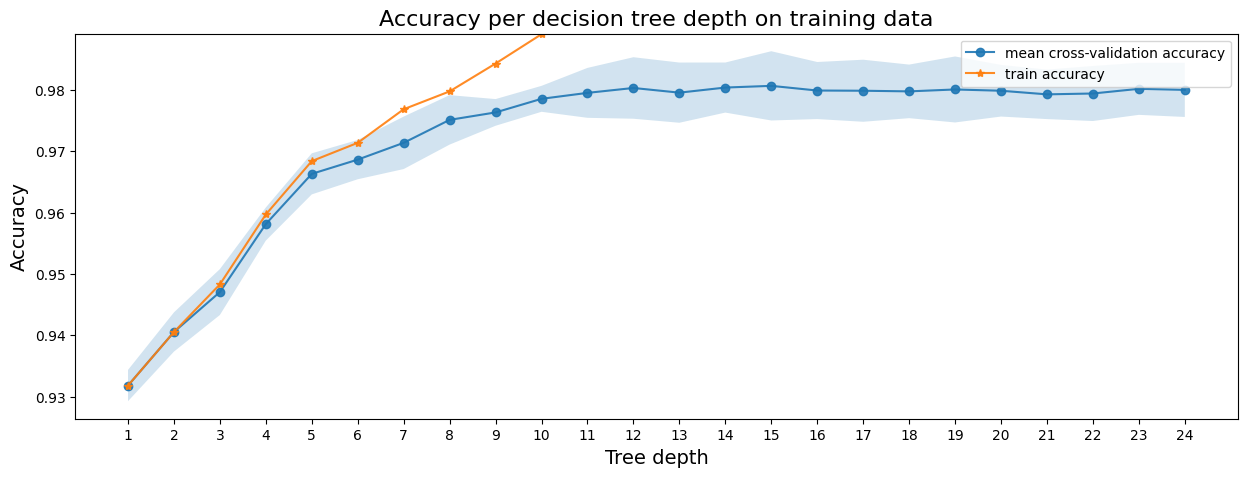

In [25]:
# Your code here (add more cells as needed)
import numpy as np
import matplotlib.pyplot as plt
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores,
                               'Accuracy per decision tree depth on training data')

In [26]:
# Your code here (add more cells as needed)
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-15 tree achieves the best mean cross-validation accuracy 98.06407 +/- 0.28208% on training dataset


In [27]:
# Your code here (add more cells as needed)
# Instantiate and fit decision tree model with max_depth=15 as recommended by the accuracy function above
tree_15_clf = DecisionTreeClassifier(max_depth=15,random_state=42)
# train the model
tree_15_clf.fit(X_train, y_train)
# evaulate the model
tree_15_log_loss_mean = -cross_val_score(tree_15_clf, X_train_scaled, y_train, scoring="neg_log_loss").mean()
tree_15_log_loss_mean

0.6582582688194408

In [28]:
# Your code here (add more cells as needed)
y_pred = tree_15_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))

Accuracy: 97.81840847704134
Precision: 0.8289655172413793
Recall: 0.8748180494905385
F1 Score: 0.8512747875354107


In [30]:
# min_samples_leaf
# Your code here (add more cells as needed)
# Instantiate and fit decision tree model with max_depth=15 as recommended by the accuracy function above
# AND set the minimum number of samples required to be at a leaf node
tree_15_samples_clf = DecisionTreeClassifier(max_depth=15,min_samples_leaf=500,random_state=42)
# train the model
tree_15_samples_clf.fit(X_train, y_train)
# evaulate the model
tree_15_samples_log_loss_mean = -cross_val_score(tree_15_samples_clf, X_train_scaled, y_train, scoring="neg_log_loss").mean()
tree_15_samples_log_loss_mean

0.14236600903893898

In [31]:
# Your code here (add more cells as needed)
y_pred = tree_15_samples_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))

Accuracy: 94.61874091003533
Precision: 0.7217847769028871
Recall: 0.4002911208151383
F1 Score: 0.5149812734082396


In [ ]:
"""
Log loss went down with the second tree, but all the other evaluation metrics are worse. Once again it depends on the use case and
business problem. But looking at log loss only (as instructed) our second decision tree with the max_depth of 15 and the min_samples_leaf of 500
performed better than the previous decision tree that only set the max depth at 15.
"""

## 6. Choose and Evaluate an Overall Best Model

Which model had the best performance? What type of model was it?

Instantiate a variable `final_model` using your best model with the best hyperparameters.

In [49]:
# Replace None with appropriate code
final_model = KNeighborsClassifier(n_neighbors=7, weights='distance')

# Fit the model on the full training data
# (scaled or unscaled depending on the model)
final_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

Now, evaluate the log loss, accuracy, precision, and recall. This code is mostly filled in for you, but you need to replace `None` with either `X_test` or `X_test_scaled` depending on the model you chose.

In [50]:
# Replace None with appropriate code
from sklearn.metrics import accuracy_score, precision_score, recall_score

preds = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)

print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("recall:   ", recall_score(y_test, preds))

log loss:  0.09529714901808627
accuracy:  0.9830666943694162
precision: 0.906832298136646
recall:    0.8500727802037845


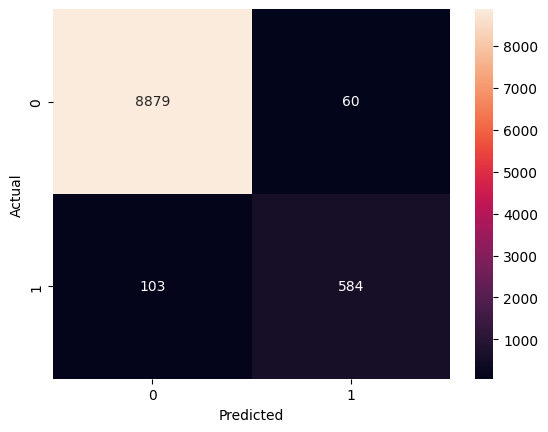

In [51]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Pred
y_pred = final_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

* TP = 584
* TN = 8879
* FP = 60
* FN = 103

Interpret your model performance. How would it perform on different kinds of tasks? How much better is it than a "dummy" model that always chooses the majority class, or the logistic regression described at the start of the lab?

In [ ]:
# Replace None with appropriate text
"""
At 98% accuracy, this model is 6% more accurate than a model which would always predict the majority class. Looking at log loss, accuracy, precision, and recall;
it would appear that our final model improved on the logistic regression model described at the top. However, the confusion matrix gives me pause.
In order to accurately judge the efficacy of a given model, I would need to know more about what the goal is for said predictive model. Are we limiting false negatives or false positives?
What is the primary use case for this model?
"""

## Conclusion

In this lab, you practiced the end-to-end machine learning process with multiple model algorithms, including tuning the hyperparameters for those different algorithms. You saw how nonparametric models can be more flexible than linear models, potentially leading to overfitting but also potentially reducing underfitting by being able to learn non-linear relationships between variables. You also likely saw how there can be a tradeoff between speed and performance, with good metrics correlating with slow speeds.